In [ ]:
!pip install --upgrade pyarrow
!pip install matplotlib
!pip install datasets # install the missing datasets module
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Load and prepare datasets
true_df = pd.read_csv(r"C:\Users\KIIT0\Downloads\News _dataset\True.csv")
fake_df = pd.read_csv(r"C:\Users\KIIT0\Downloads\News _dataset\Fake.csv")

# Assign labels: 1 for real news, 0 for fake news
true_df['label'] = 1
fake_df['label'] = 0

# Combine true and fake datasets
df = pd.concat([true_df[['text', 'label']], fake_df[['text', 'label']]], ignore_index=True)

# 2. Split into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Tokenization using ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize the text data with a reduced max_length of 64
def tokenize_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# Convert train and test DataFrames to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

# Set format for PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 4. Define metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# 5. Training arguments with optimizations
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Set 3 epochs as requested
    per_device_train_batch_size=16,  # Keep a reasonable batch size to avoid OOM issues
    per_device_eval_batch_size=16,
    warmup_steps=100,                # Reduced warmup steps for faster learning
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,                       # Enable mixed precision for faster training
    learning_rate=5e-5,              # Optimized learning rate for faster convergence
)

# Load ALBERT model
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 6. Train the model
trainer.train()

# 7. Evaluate the model
results = trainer.evaluate()
print(f"Validation Accuracy: {results['eval_accuracy']:.2f}")

# 8. Visualizations

# Extract logged evaluation accuracy and training loss
log_history = trainer.state.log_history
eval_acc = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
train_loss = [log['loss'] for log in log_history if 'loss' in log]

# Plot validation accuracy per epoch
plt.figure(figsize=(10, 5))
plt.plot(eval_acc, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict labels on the test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Confusion matrix
true_labels = test_df['label'].values
cm = confusion_matrix(true_labels, pred_labels)

# Display confusion matrix
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


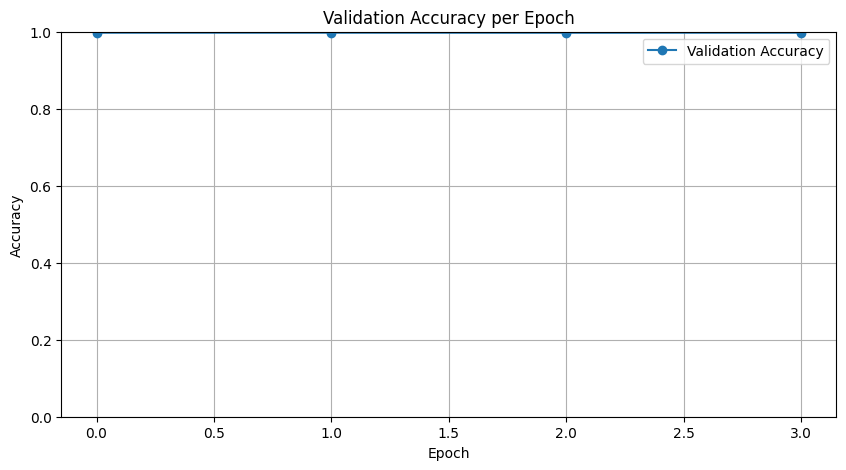

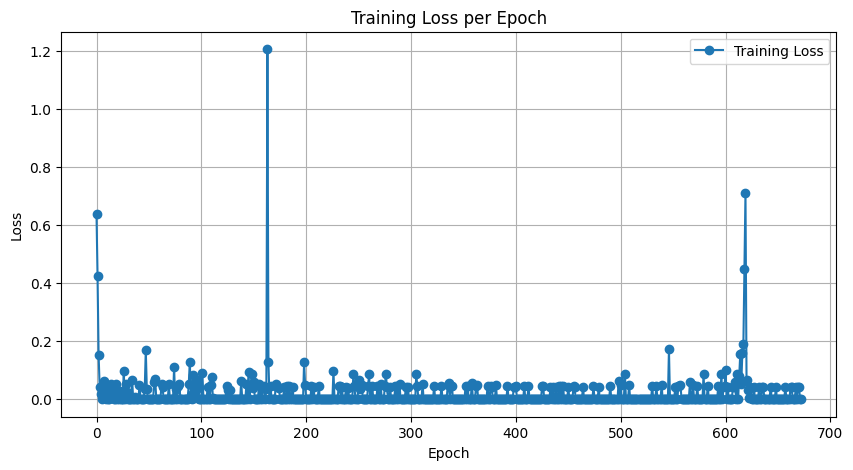

In [2]:
# prompt: give loss and accuracy graphs for the above model

# Extract logged evaluation accuracy and training loss
log_history = trainer.state.log_history
eval_acc = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
train_loss = [log['loss'] for log in log_history if 'loss' in log]

# Plot validation accuracy per epoch
plt.figure(figsize=(10, 5))
plt.plot(eval_acc, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


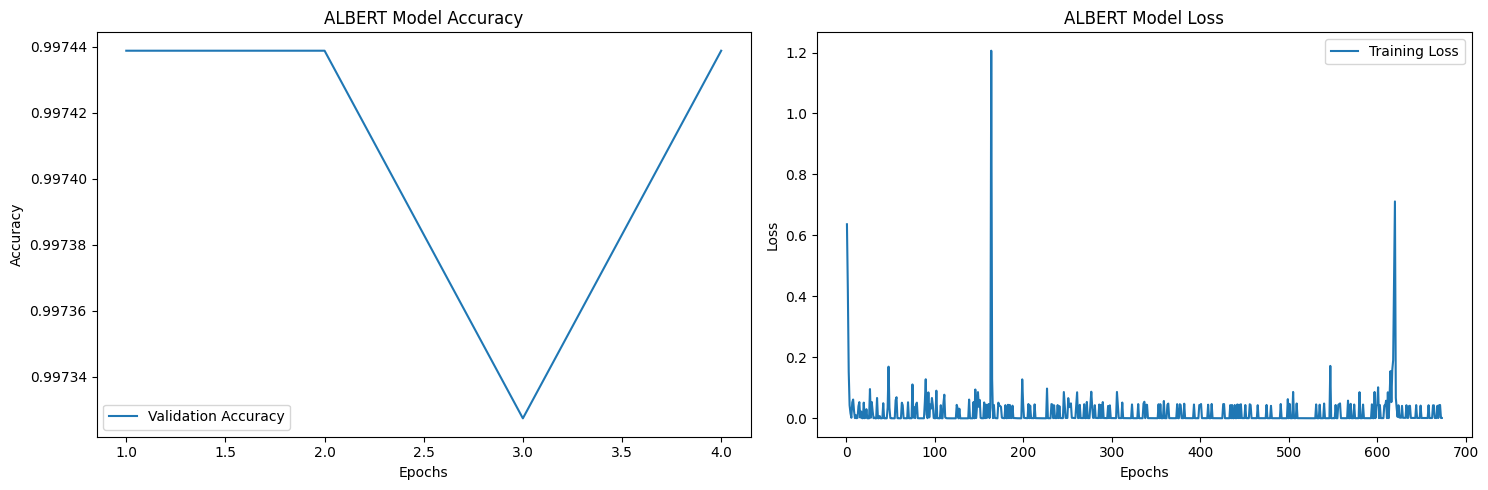

In [11]:
# prompt: keep reference of above graph code of lstm and give the graph for the above trained albert model with all the results obtained give the same as that code output for our code

# Extract logged evaluation accuracy and training loss
log_history = trainer.state.log_history
eval_acc = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
train_loss = [log['loss'] for log in log_history if 'loss' in log]

# Plot validation accuracy per epoch
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, label='Validation Accuracy')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ALBERT Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ALBERT Model Loss')

plt.tight_layout()
plt.show()


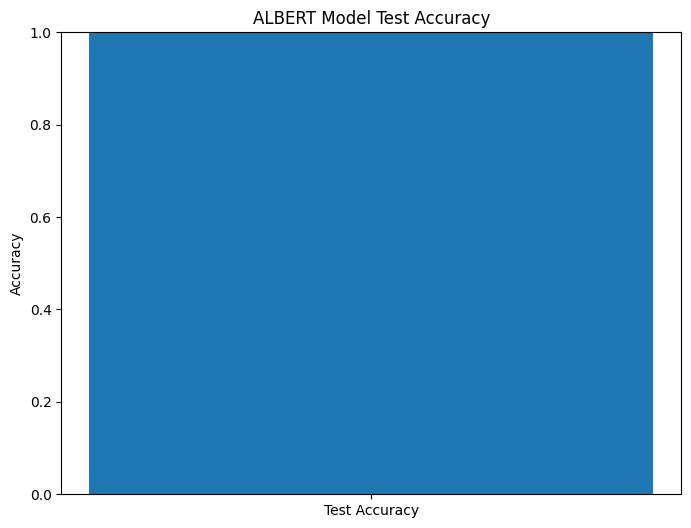

In [12]:
# prompt: give the code for showing test accuracy in graph for the albert model which is trained above

# Predict labels on the test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(test_df['label'].values, pred_labels)

# Plot test accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Test Accuracy'], [test_accuracy])
plt.title('ALBERT Model Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


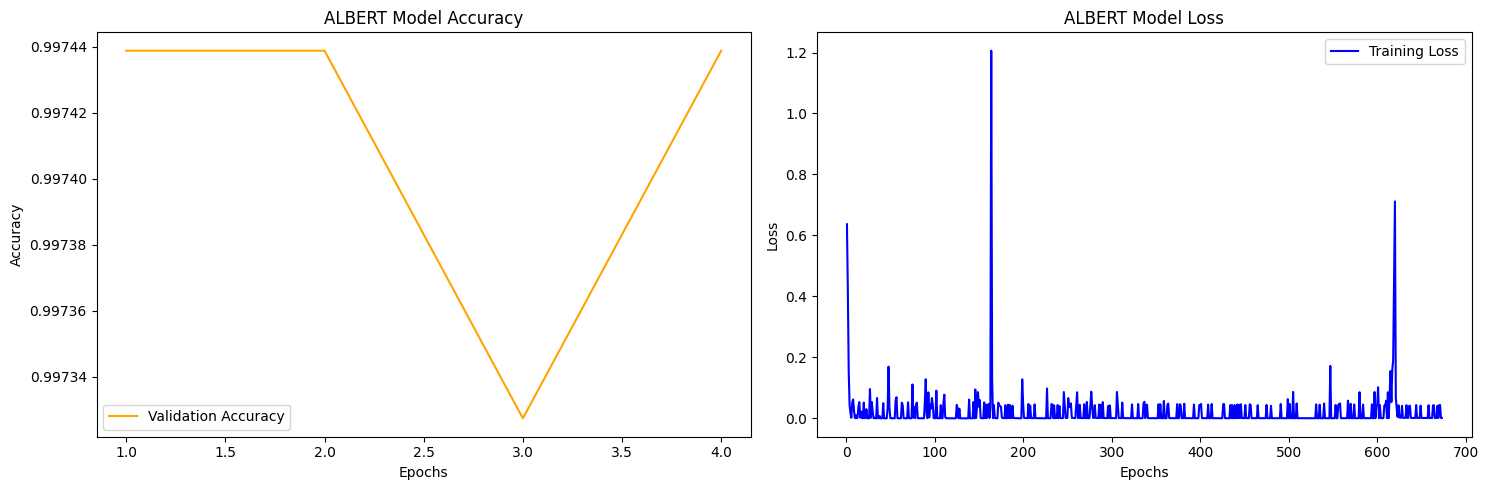

In [13]:
# prompt: use the above code as reference and give the graph for albert model correctly segrgte val set and train with orange and blue and give the graph

# ... (Your existing code from the preceding code block) ...

# Extract logged evaluation accuracy and training loss
log_history = trainer.state.log_history
eval_acc = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
train_loss = [log['loss'] for log in log_history if 'loss' in log]

# Plot validation accuracy per epoch
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, label='Validation Accuracy', color='orange')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ALBERT Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ALBERT Model Loss')

plt.tight_layout()
plt.show()

# ... (Rest of your existing code) ...


In [6]:
# prompt: analyse and give me the classification report for the above model give accurate results

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])

print(report)


              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4650
        Real       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [10]:
# prompt: give me the different code for the above model for taking user input its throwing error as RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select) i should get this error and predict true or fake

def predict_news_article(news_article):
  """Predicts whether a news article is true or fake using the trained model.

  Args:
    news_article: The text of the news article.

  Returns:
    A string indicating whether the news article is predicted to be true or fake.
  """

  inputs = tokenizer(news_article, padding='max_length', truncation=True, max_length=64, return_tensors='pt').to(model.device)  # Move input to the same device as the model
  outputs = model(**inputs)
  prediction = torch.argmax(outputs.logits).item()

  if prediction == 1:
    return "True"
  else:
    return "Fake"


# Get user input for a news article
user_input_news_article = input("Enter the news article: ")


# Predict whether the news article is true or fake
prediction_result = predict_news_article(user_input_news_article)

print(f"The news article is predicted to be: {prediction_result}")


Enter the news article: MEXICO CITY (Reuters) - Mexico’s finance ministry will evaluate whether to make fiscal changes in response to the U.S. tax reform, according to a document seen by Reuters on Friday. In the document, the ministry said Mexico would not make changes that left it with a higher public sector deficit. “Nevertheless, there will be an assessment of whether modifications should be made to Mexico’s fiscal framework,” the document said. 
The news article is predicted to be: True
